# 2D Optimize Over Two Decoupled Functions

In [1]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS

In [2]:
# Step 1: Initialize FEM System
mesh = fem.MeshTri.init_sqsymmetric().refined(3)
element = fem.ElementTriP1()
intorder = 3 # High order to capture everything accurately

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)

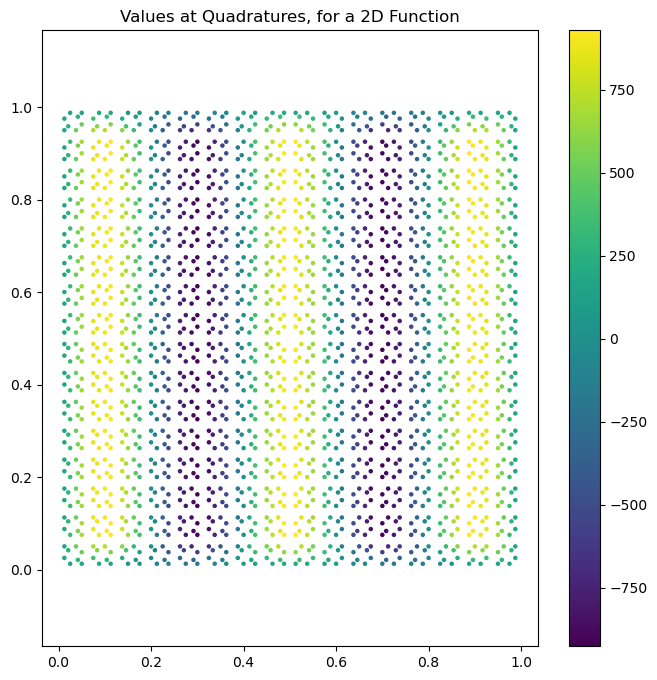

In [3]:
# Step 2: Define Optimization Objective
def kinetic(u1,grad_u1,u2,grad_u2,x):
    ke = jnp.sum(grad_u1**2 + grad_u2**2, axis=0) 
    return ke

def v1(x_vec):
    x,y = x_vec[0],x_vec[1]
    return 1000 * jnp.sin(5*jnp.pi*x) + 100 * (y-0.5)**2

def v2(x_vec):
    x,y = x_vec[0],x_vec[1]
    return 100 * jnp.cos(4*jnp.pi*y) + 100 * (x-0.5)**2

def pot1(u,grad_u,x):
    return v1(x) * u**2

def pot2(u,grad_u,x):
    return v2(x) * u**2

# def interaction(u,grad_u,x):
#     return u**2

def unpack(u_interior_total):
    l_interior = len(femsystem.interior_dofs)
    u1_interior,u2_interior = u_interior_total[:l_interior],u_interior_total[l_interior:]
    return u1_interior,u2_interior

def objective(u_interior_total):
    u1_interior,u2_interior = unpack(u_interior_total)
    u1,u2 = femsystem.apply_bc_and_norm(u1_interior), femsystem.apply_bc_and_norm(u2_interior)

    kinetic_integrals = femsystem.integrate_two(kinetic,u1,u2)
    potential_integrals = femsystem.integrate(pot1,u1) + femsystem.integrate(pot2,u2)

    final_obj = kinetic_integrals + potential_integrals 

    return final_obj

femsystem.plot_values_2d(lambda a,b: v1([a,b]))

In [4]:
# Interior nodes are those NOT in boundary_dofs, TWICE for two functions
u_init_interior = jnp.ones(len(femsystem.interior_dofs)*2)

print("\nStarting Optimization...")

# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params # The interior points


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 39.41987228393555 Objective Value:225.6788330078125  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 21.26238250732422 Objective Value:-135.86575317382812  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 13.469412803649902 Objective Value:-325.5490417480469  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 5.39195442199707 Objective Value:-572.92578125  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 5.953195095062256 Objective Value:-609.7288208007812  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 2.3304378986358643 Objective Value:-623.2166137695312  Stepsize:1.0  Number Linesearch Iteratio

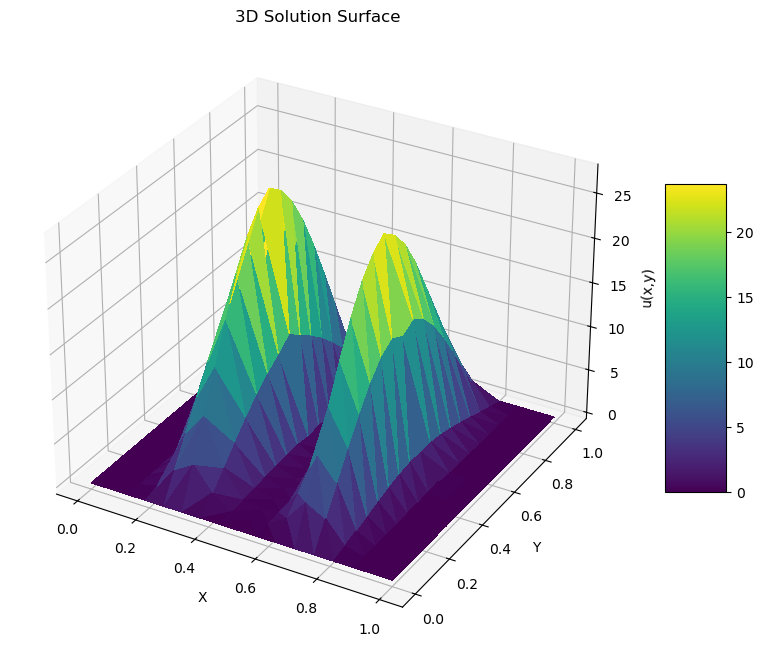

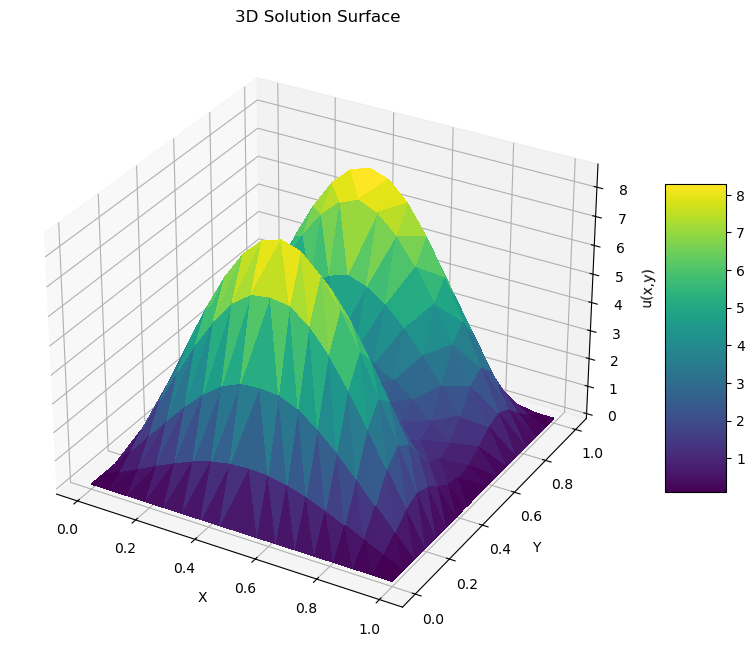

1.0


In [5]:
u1_result_interior,u2_result_interior = unpack(result)
femsystem.plot_at_interior_2d_in3d(u1_result_interior,plot_title="U1")
femsystem.plot_at_interior_2d_in3d(u2_result_interior,plot_title="U2")
print(femsystem.integrate(lambda u,grad_u,x: x,femsystem.apply_bc_and_norm(u2_result_interior)))